In [2]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Optional
from pathlib import Path

from skimage.filters import threshold_otsu, meijering
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_dilation
from skimage.restoration import inpaint
from scipy.ndimage import gaussian_filter
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from tifffile import imread

(np.float64(-0.5), np.float64(16319.5), np.float64(12239.5), np.float64(-0.5))

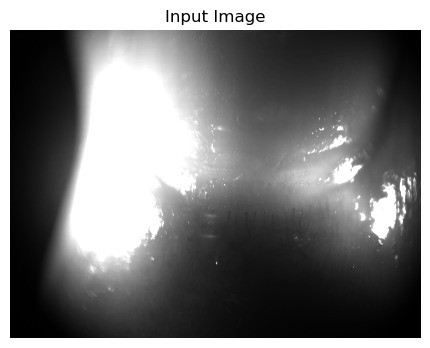

In [3]:
IMG_PATH = "../_images/C2-20250829_001448.tif"
PIXEL_SIZE_UM = 0.6

img = imread(IMG_PATH)

plt.figure(figsize=(6,4)); plt.imshow(img, cmap='gray'); plt.title("Input Image"); plt.axis('off')


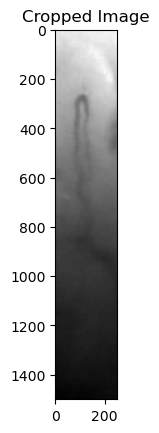

In [4]:
cropped_img_1 = img[7000:8500, 10000:10250] 
plt.imshow(cropped_img_1, cmap='gray')
plt.title("Cropped Image")
plt.show()

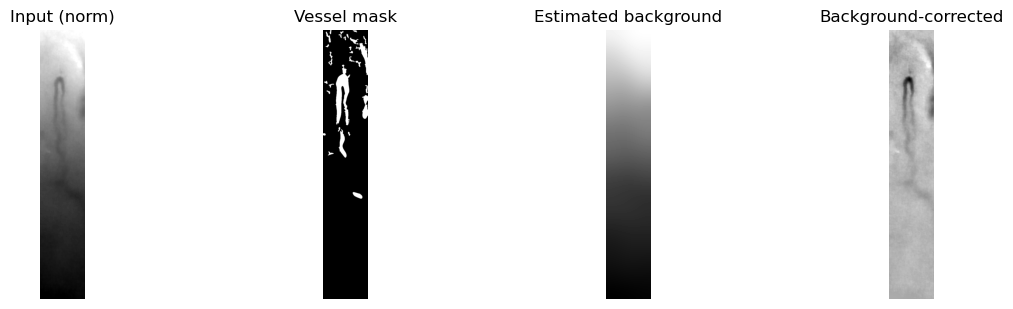

In [5]:
img_crop = cropped_img_1.astype(np.float32)
p1, p99 = np.percentile(img_crop, (1, 99))
img_n = np.clip((img_crop - p1) / (p99 - p1 + 1e-8), 0, 1)

# 1) Vessel mask (dark ridges)
sigmas = np.geomspace(3, 17, 7)  
resp = meijering(img_n, sigmas=sigmas, black_ridges=True)
resp = (resp - resp.min()) / (resp.max() - resp.min() + 1e-8)
BW = resp > threshold_otsu(resp)

# Cleanup & give some margin around vessels
BW = remove_small_objects(BW, min_size=100)
BW = remove_small_holes(BW, area_threshold=200)
BW = binary_dilation(BW, disk(1))          

# 2) Inpaint vessel regions
mask = BW.astype(bool)
img_inp = inpaint.inpaint_biharmonic(img_n, mask, channel_axis=None)

# 3) Low-pass the inpainted image to get background (use scale >> vessel width)
bg = gaussian_filter(img_inp, sigma=60)    

# 4) Background correction (keep range sane)
img_corr = np.clip(img_n - bg + bg.mean(), 0, 1)

fig, ax = plt.subplots(1,4, figsize=(14,3.5))
ax[0].imshow(img_n, cmap='gray'); ax[0].set_title('Input (norm)'); ax[0].axis('off')
ax[1].imshow(BW, cmap='gray');    ax[1].set_title('Vessel mask'); ax[1].axis('off')
ax[2].imshow(bg, cmap='gray');    ax[2].set_title('Estimated background'); ax[2].axis('off')
ax[3].imshow(img_corr, cmap='gray'); ax[3].set_title('Background-corrected'); ax[3].axis('off')
plt.show()

In [6]:
@dataclass
class VesselCalib:
    p1: float
    p99: float
    black_ridges: bool
    sig_lo: float
    sig_hi: float
    sig_n: int
    sigma_bg: float
    min_size: int = 100
    hole_area: int = 200
    dilate_r: int = 1

def calibrate_from_roi(roi,
                       sigma_bg: float = 60,
                       sig_lo: float = 3, sig_hi: float = 17, sig_n: int = 7,
                       polarity: str = 'dark') -> VesselCalib:
    roi = roi.astype(np.float32)
    p1, p99 = np.percentile(roi, (1, 99))
    black_ridges = (polarity == 'dark')
    return VesselCalib(
        p1=p1, p99=p99,
        black_ridges=black_ridges,
        sig_lo=sig_lo, sig_hi=sig_hi, sig_n=sig_n,
        sigma_bg=sigma_bg
    )

def estimate_bg_raw(full_img, *,
                    sigma_bg=60,
                    sig_lo=3, sig_hi=17, sig_n=7,
                    max_side=3000,
                    p1=None, p99=None,
                    black_ridges=True,
                    min_size=100, hole_area=200, dilate_r=1):
    """Return bg_raw: smooth background field in ORIGINAL units."""
    img = full_img.astype(np.float32)
    H, W = img.shape[:2]

    # normalization (freeze p1,p99 if provided)
    if p1 is None or p99 is None:
        p1, p99 = np.percentile(img, (1, 99))
    A = (p99 - p1) + 1e-6
    img_n = np.clip((img - p1) / A, 0, 1)

    ds = min(1.0, max_side / max(H, W))
    h, w = int(H*ds), int(W*ds)
    img_s = resize(img_n, (h, w), order=1, preserve_range=True).astype(np.float32)

    # vessel mask (Meijering), then light cleanup
    sigs = np.geomspace(sig_lo, sig_hi, sig_n) * ds
    resp = meijering(img_s, sigmas=sigs, black_ridges=black_ridges)
    BW = resp > threshold_otsu(resp)
    BW = remove_small_objects(BW, min_size=int(max(1, round(min_size*ds*ds))))
    BW = remove_small_holes(BW, area_threshold=int(max(1, round(hole_area*ds*ds))))
    BW = binary_dilation(BW, disk(max(1, int(round(dilate_r*ds)))))

    img_inp = inpaint.inpaint_biharmonic(img_s, BW, channel_axis=None)
    bg_s = gaussian_filter(img_inp, sigma=sigma_bg * ds)
    bg = resize(bg_s, (H, W), order=1, preserve_range=True).astype(np.float32)

    bg_raw = bg * A + p1
    return bg_raw


In [7]:
cal = calibrate_from_roi(
    cropped_img_1,
    sigma_bg=60,
    sig_lo=3, sig_hi=17, sig_n=7,
    polarity='dark'
)

bg_raw = estimate_bg_raw(
    img,
    p1=cal.p1, p99=cal.p99,              
    sigma_bg=cal.sigma_bg,
    sig_lo=cal.sig_lo, sig_hi=cal.sig_hi, sig_n=cal.sig_n,
    black_ridges=cal.black_ridges,
    max_side=3000,
    min_size=cal.min_size, hole_area=cal.hole_area, dilate_r=cal.dilate_r
)

In [ ]:
src = Path(IMG_PATH)
out_bg_raw = src.with_name(f"{src.stem}_background_raw.tif")

write_kwargs = {}
if PIXEL_SIZE_UM is not None:
    ppcm = 10000.0 / float(PIXEL_SIZE_UM)  # pixels per cm
    write_kwargs.update(dict(resolution=(ppcm, ppcm), resolutionunit="CENTIMETER"))

tifffile.imwrite(
    out_bg_raw.as_posix(),  
    bg_raw.astype(np.float32),
    compression="zlib",
    metadata={"axes": "YX"},
    bigtiff=True,
    **write_kwargs
)
print(f"Saved RAW background to: {out_bg_raw}")

Saved RAW background to: ../_images/C2-20250829_001448_background_raw.tif
